Discount 0.9615
  65 :    17507     14123      7838         0 
  66 :    17088     13776      7619         0 
  67 :    16660     13422      7397         0 
  68 :    16224     13063      7173         0 
  69 :    15781     12698      6946         0 
  70 :    15331     12329      6717         0 
  71 :    14875     11955      6487         0 
  72 :    14413     11577      6254         0 
  73 :    13945     11195      6021         0 
  74 :    13473     10811      5787         0 
  75 :    12997     10424      5553         0 
  76 :    12517     10035      5319         0 
  77 :    12035      9645      5085         0 
  78 :    11551      9255      4853         0 
  79 :    11066      8864      4622         0 
  80 :    10581      8475      4393         0 
  81 :    10098      8088      4166         0 
  82 :     9617      7703      3943         0 
  83 :     9139      7321      3723         0 
  84 :     8666      6944      3508         0 
  85 :     8199      6572      3297         

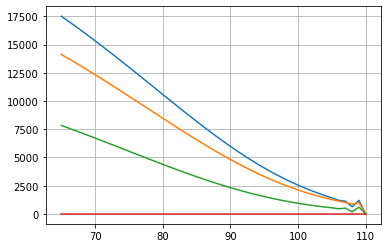

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = []
        self.dPre = []
        self.dPost= []
        self.dv   = []
        self.dDK  = []
        self.dDKDistr  = []
        
        self.bCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 30000
        self.iNrBuckets = 3300
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.
                
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)
    
    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)
    
    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)
    
    def vSetDiscount(self,fIRate):
        vTemp = 1./(1.+fIRate)
        print("Discount %.4f"%(vTemp))
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
    
    def vSetPij(self,t,i,j,fValue):
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
    
    def vSetPre(self,t,i,j,fValue):
        self.dPre[t][i] = fValue
        self.bCalculated = False
    
    def vSetPost(self,t,i,j,fValue):
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
    
    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])
                    
    def doCalculateDKDistr(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation                   
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])
                                      
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])
    
    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.0f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)
    
    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle=""):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc)
                    x.append(xLoc)
                    y.append(yLoc)
    
                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1
        
def mu(x):
    return(np.exp(-7.85785 + 0.01538*x + 0.000577355*x**2))

symMB = Markov()
symMB.vDefineModel(4) # (**), (t*), (*t), (tt)
symMB.vSetDiscount(0.04)

iStart = 110
iStop = 65
AnnuityJoint = 1200 # aPre**
AnnuityWiddow = 1000 # aPret*
AnnuityWiddower = 600 # aPre*t
iDxy = -3 # y-x - "2nd person 3 yrs younger"

for i in range(iStop,iStart):
    qx = mu(i)
    qy = mu(i+iDxy)
    symMB.vSetPij(i,0,0,(1-qx)*(1-qy))
    symMB.vSetPij(i,0,1, qx*(1-qy))
    symMB.vSetPij(i,0,2,(1-qx)*qy)
    symMB.vSetPij(i,0,3,qx*qy)
    symMB.vSetPij(i,1,1, (1-qy))
    symMB.vSetPij(i,1,3, (qy))
    symMB.vSetPij(i,2,2, (1-qx))
    symMB.vSetPij(i,2,3, (qx))
    symMB.vSetPij(i,3,3, 1.)

    
for i in range(iStop,iStart):
    symMB.vSetPre(i,0,0,AnnuityJoint)
    symMB.vSetPre(i,1,1,AnnuityWiddow)
    symMB.vSetPre(i,2,2,AnnuityWiddower)

symMB.PrintDKs(iStart,iStop)

symMB.PlotDKs(iStart,iStop)
